# Optical Forces Calculation

To demonstrate how a neural network can be used as an emulator of a physical system, we'll implement a dense neural network to calculate the forces acting on an optically trapped particle.

## The Dataset with Optical Forces in Geometrical Optics

The following code will download the optical force dataset repository from the GitHub repository https://github.com/DeepTrackAI/optical_forces_dataset, only if the `optical_forces_dataset` directory doesn't already exist.

In [193]:
import os

if not os.path.exists("optical_forces_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/optical_forces_dataset")

First, we load the theoretical values of the optical force along the z-axis $f_z$ as a function of the z-coordinate, i.e., $f_z(z)$, from the file `fz_vs_z_theory.txt`, which contains two columns corresponding to the z-position in micrometers and to the z-component of the optical force in piconewtons.

In [194]:
import numpy as np

fz_vs_z_path = os.path.join("optical_forces_dataset", "fz_vs_z_theory.txt")

data_theory = [] 
with open(fz_vs_z_path, "r") as file:
	for line in file:
		row = []
		for number in line.split(","):
			row.append(float(number))
		data_theory.append(row)

data_theory = np.array(data_theory)
z_theory = data_theory[:, 0]
fz_theory = data_theory[:, 1] * 1e3 # conversion from pN to fN

print(f"Theory: {len(z_theory)} positions and {len(fz_theory)} forces")

Theory: 101 positions and 101 forces


Then, we load the optical forces calculated with the geometrical optics approach from two pre-saved NumPy array contained in `xyz_go_100rays.npy` (4D NumPy array with the x, y and z position of the particle where the optical forces are calculated) and `fxyz_go_100rays.npy` (4D NumPy array with the x-, y- and z-components of the optical force at each position), and extract the positions and forces that are relevant for us.

In [195]:
xyz_go = np.load(os.path.join("optical_forces_dataset", "xyz_go_100rays.npy"))
z_go = xyz_go[50, 50, :, 2]

fxyz_go = np.load(os.path.join("optical_forces_dataset", "fxyz_go_100rays.npy"))
fz_go = fxyz_go[50, 50, :, 2]

print(f"GO: {len(z_go)} positions and {len(fz_go)} forces")

GO: 101 positions and 101 forces


Finally, we plot the comparison between the theoretical and computed optical forces.

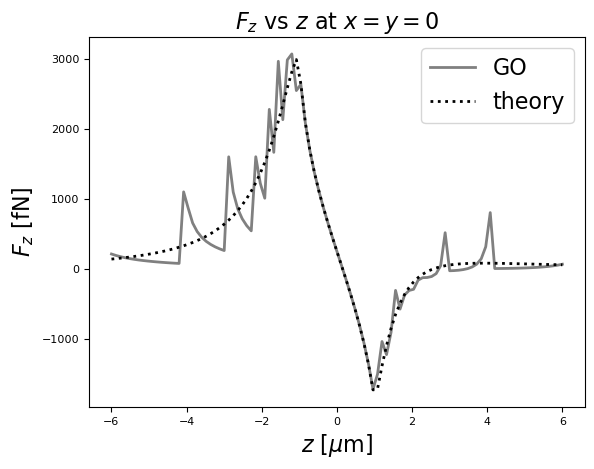

In [196]:
import matplotlib.pyplot as plt

plt.plot(z_go, fz_go, c="gray",linewidth=2, label="GO")
plt.plot(z_theory, fz_theory, c="k", linewidth=2, linestyle=":", label="theory")
plt.title("$F_z$ vs $z$ at $x=y=0$", fontsize=16)
plt.xlabel("$z$ [$\mu$m]", fontsize=16)
plt.ylabel("$F_z$ [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.legend(fontsize=16)
plt.show()

## Load Training Data

The training data are contained in the files in the directory `sphere_100rays`. There are 101 files with names `force_grid_3D=1.txt`, `force_grid_3D=2.txt`, and so on. Each row in these files consists of eight numbers with the following format: $[R, n_{\rm p}, x, y, z, f_{\rm x}, f_{\rm y}, f_{\rm z}]$, where $R \equiv 1^{−6}\,{\rm m}$ is the particle radius, $n_{\rm p} \equiv 1.5$ is its refractive index, $(x,y,z)$ are its position (in meters), and $(f_{\rm x}, f_{\rm y}, f_{\rm z})$ are its force (in Newtons). 

Each file can be loaded with the function `load_data_file()`, which keeps only the positions converted in micrometers and the forces converted in femtonewtons.

In [197]:
def load_data_file(filename):
    data = []
    with open(filename, "r") as file:
        for line in file:
            row = []
            count = 0
            for number in line.split():
                if 2 <= count <= 4:
                    row.append(float(number) * 1e6) # from m to um
                elif 5 <= count <= 7:
                    row.append(float(number) * 1e15) # from N to fN
                count += 1
            data.append(row)
        return np.array(data)
    
data = load_data_file(os.path.join("optical_forces_dataset", "sphere_100rays", "force_grid_3D=1.txt"))
print(data)

[[  -4.          -4.          -6.           0.           0.
     0.       ]
 [  -4.          -4.          -5.88         0.           0.
     0.       ]
 [  -4.          -4.          -5.76       -37.2116747  100.147531
    93.7947815]
 ...
 [  -4.           4.           5.76      -137.597649   -27.1503227
    21.4702215]
 [  -4.           4.           5.88         0.           0.
     0.       ]
 [  -4.           4.           6.           0.           0.
     0.       ]]


We can now load all data iterating over all files.

In [198]:
data = np.empty((0, 6))
for i in range (1, 102):
    filename = os.path.join("optical_forces_dataset", "sphere_100rays", f"force_grid_3D={i}.txt")
    data = np.append(data, load_data_file(filename), axis=0)

print(f"{np.shape(data)[0]} data points with {np.shape(data)[1]} variables each")

1030301 data points with 6 variables each


## Split Training and Validation Data

We now split the data between a training set and a validations set.

In [199]:
train_split = .80

np.random.shuffle(data) # in-place shuffle

train_size = int(len(data) * train_split)

data_train = data[:train_size]
xyz_train = data_train[:, :3]
fxyz_train = data_train[:, 3:]

data_val = data[train_size:]
xyz_val = data_val[:, :3]
fxyz_val = data_val[:, 3:]

print(f"{len(xyz_train)} training datapoints")
print(f"{len(xyz_val)} validation datapoints")

824240 training datapoints
206061 validation datapoints


## Neural Network

We will create, train, and evaluate the neural network.

### Neural Network Model

We use the class `MultiLayerPerceptron` from `deeplay` to create a _dense neural network_ with three inputs (the particle positions $(x,y,z)$, `.in_features(3)`), three hidden layers with 256 neurons each (`.hidden_dims([256, 256, 256])`), and three outputs (the three components of the force $(f_{\rm x}, f_{\rm y}, f_{\rm z})$, `.out_features(3)`).

In [200]:
import deeplay as dl

mlp_config = (dl.Config()
    .in_features(3)
    .hidden_dims([256, 256, 256])
    .out_features(3)
)
mlp_model = dl.MultiLayerPerceptron.from_config(mlp_config)

print(mlp_model)
print(f"{sum(p.numel() for p in mlp_model.parameters())} trainable parameters")

MultiLayerPerceptron(
  (in_features): 3
  (hidden_dims): [256, 256, 256]
  (out_features): 3
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=3, out_features=256, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (1-2): 2 x Template(
      (layer): Linear(in_features=256, out_features=256, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=256, out_features=3, bias=True)
  (out_activation): Identity()
)
133379 trainable parameters


### Application as Regressor

We use the `Regressor` application class from `deeplay` to define what we want to do with the neural network.

We add to the regressor the model we have just created (`.model(dt.MultiLayerPerceptron, mlp_config)`). Then, we set _mean squared error_ as loss function (`.loss(MSELoss)`), and set _Adam_ as optimizer (`.optimizer(Adam)`).

In [201]:
from torch.nn import MSELoss
from torch.optim import Adam

regressor_config = (dl.Config()
    .model(dl.MultiLayerPerceptron, mlp_config)
    .loss(MSELoss)
    .optimizer(Adam)
)
regressor = dl.Regressor.from_config(regressor_config)
    
print(regressor)

Regressor(
  (model): MultiLayerPerceptron(
    (in_features): 3
    (hidden_dims): [256, 256, 256]
    (out_features): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=3, out_features=256, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
      (1-2): 2 x Template(
        (layer): Linear(in_features=256, out_features=256, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=256, out_features=3, bias=True)
    (out_activation): Identity()
  )
  (loss): MSELoss()
)


### Implementing Data Loaders

Now, we define a custom dataset. This dataset contains pairs of input data (`x`) and corresponding target data (`y`). We do this by creating a class called `MyDataset` that inherits from PyTorch's `Dataset` class. This class will handle tasks like initializing the dataset, determining its length, and retrieving individual samples. 

We also set up data loaders using these datasets, which will allow us to efficiently load and process data in batches during the training and validation phases of the neural network. Each batch will contain 1024 samples, which helps streamline the training process.


In [202]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx].astype(np.float32), self.y[idx].astype(np.float32))


train_dataset = MyDataset(xyz_train, fxyz_train)
train_dataloader = dl.DataLoader(train_dataset, batch_size=1024)

val_dataset = MyDataset(xyz_val, fxyz_val)
val_dataloader = dl.DataLoader(val_dataset, batch_size=1024)

### Training

To start training our neural network, we use the `trainer.fit()` method. This command manages the training process, carrying out essential tasks such as forward and backward passes, updating parameters, and keeping a record of the progress. The training runs for a specified number of times — in our case, 10 epochs. Additionally, we use `val_dataloader` to evaluate the model's performance on a different dataset to validate our results.

The `CSVLogger` acts as a recorder. It is passed as input to the training process (`trainer.fit()`), allowing it to keep track of important training information. `CSVLogger` creates a folder called "logs" to store the results in an orderly manner. Inside this folder, the logger records various training metrics and outcomes in a structured CSV file for easy reference. Additionally, the `log_every_n_steps` parameter serves as a control knob for how often the training progress is saved by the `CSVLogger`. In this case, it's set to 20, meaning that for every 20 training steps, the model's current performance metrics are recorded.

In [203]:
from lightning.pytorch.loggers import CSVLogger

trainer = dl.Trainer(
    max_epochs=100, 
    accelerator="auto", 
    logger=CSVLogger("logs", name="regressor"), 
    log_every_n_steps=20
    )

trainer.fit(regressor, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/regressor

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | MultiLayerPerceptron | 133 K 
1 | loss  | MSELoss              | 0     
-----------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.534     Total estimated model params size (MB)


/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 805/805 [00:19<00:00, 40.85it/s, v_num=0, train_loss_step=1.85e+3, val_loss_step=1.97e+3, val_loss_epoch=2.02e+3, train_loss_epoch=1.7e+3] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 805/805 [00:19<00:00, 40.83it/s, v_num=0, train_loss_step=1.85e+3, val_loss_step=1.97e+3, val_loss_epoch=2.02e+3, train_loss_epoch=1.7e+3]


`CSVLogger` creates a new version folder each time the training process is executed. This version folder, labeled with a specific number (in this case, version 0), serves as a snapshot of the training session. It contains a CSV file named `metrics.csv`, which logs the training metrics and outcomes.

To access and analyze these results, we use the `pandas` library, a powerful tool for data manipulation and analysis in Python.

Within the `metrics.csv` file, information on each epoch's performance is stored in specific columns. The `train_loss_epoch` column holds the training loss for each epoch, while the `val_loss_epoch` column contains the validation loss. By extracting and examining this data, we can assess the performance of our neural network and make informed decisions about potential adjustments or optimizations.

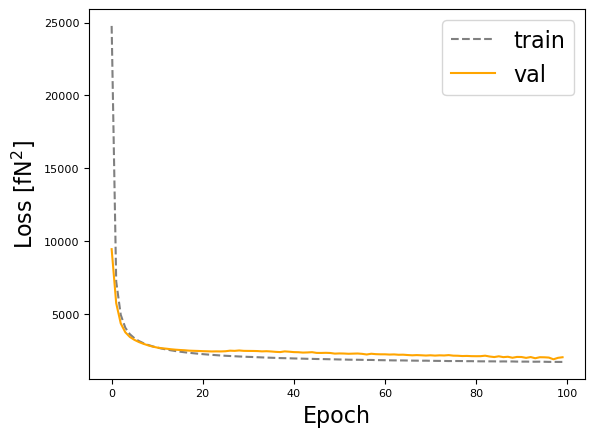

In [204]:
import pandas as pd

version = 0
logs = pd.read_csv(f"logs/regressor/version_{version}/metrics.csv")

# Group by epoch and extract train loss
train_epoch = logs[logs.train_loss_epoch.notnull()].epoch
train_loss = logs[logs.train_loss_epoch.notnull()].train_loss_epoch

# Group by epoch and extract val loss
val_epoch = logs[logs.val_loss_epoch.notnull()].epoch
val_loss = logs[logs.val_loss_epoch.notnull()].val_loss_epoch

# plot
plt.plot(val_epoch, train_loss, label="train", c="gray", linestyle='--')
plt.plot(val_epoch, val_loss, label="val", c="orange")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss [fN$^2$]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.legend(fontsize=16)
plt.show()

## Test

We'll now test the performance of our trained neural network and compare it with the theoretical and geometrical optics results.

First, we'll create a tensor with the positions where the force should be evaluated and move it to the same device (e.g., CPU or GPU) of the `regressor` neural network.

Then, we'll use the neural network to predict the forces. The tensor `positions_nn` is fed into the `regressor` neural network model to predict the forces. The output is a tensor.
The `cpu()` method is called on the result to ensure the tensor is moved to the CPU if it's not already there.
The `detach()` method is used to create a new tensor that does not have gradient information. It's necessary when you are only doing forward passes and do not intend to call `backward()` for gradients, often the case in inference mode.
Finall, the `numpy()` method converts the tensor to a NumPy array.

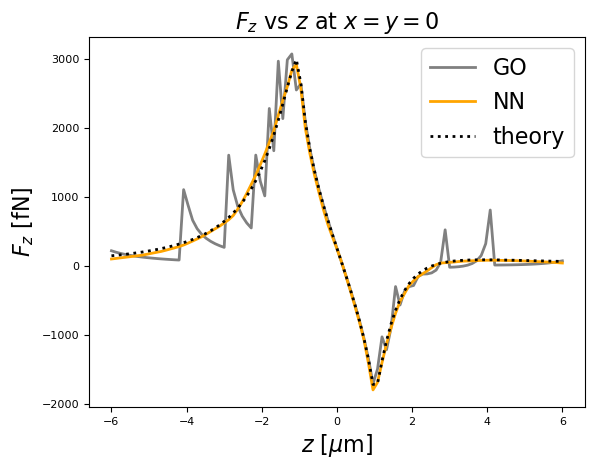

In [205]:
import torch

positions_nn = torch.zeros((z_theory.shape[0], 3))
positions_nn[:, 2] = torch.from_numpy(z_theory)
positions_nn = positions_nn.to(regressor.device)

forces_nn = regressor(positions_nn).cpu().detach().numpy()
fz_nn = forces_nn[:, 2]

plt.plot(z_go, fz_go, c="gray",linewidth=2, label="GO")
plt.plot(z_theory, fz_nn, c="orange",linewidth=2, label="NN")
plt.plot(z_theory, fz_theory, c="k", linewidth=2, linestyle=":", label="theory")
plt.title("$F_z$ vs $z$ at $x=y=0$", fontsize=16)
plt.xlabel("$z$ [$\mu$m]", fontsize=16)
plt.ylabel("$F_z$ [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.legend(fontsize=16)
plt.show()

## Simulation of an Optically Trapped Particle

We will now simualte the motion of a Brownian particle in an optical trap. The neural network will therefore work as a physical emulator of the optical forces.

from math import pi
from tqdm import tqdm

# Parameters
kB = 1.3806e-23 # Boltzman constant [(kg m^2)/(K s^2)]

laser_power = 5e-3 # laser power [W]
T = 293 # absolute temperature [K]
R = 1.0e-6 # radius [m]
eta = 1e-3 # viscosity [Pa s]

gamma = 6 * pi * eta * R # friction coefficient
D = kB * T / gamma # diffusion coefficient

N = 1_0000 # number of simulation steps
delta_t = 0.001 # simulation time step [s]

# Simulation
pos = np.zeros((N, 3))
forces = np.zeros((N, 3))
for t in tqdm(range(N - 1)):
    pos_t = pos[t:t + 1]

    pos_t_torch = from_numpy(pos_t).float().to(regressor.device) * 1e6
    forces[t + 1] = regressor(pos_t_torch).cpu().detach().numpy() * 1e-15

    pos[t + 1] = (
        + np.sqrt(2 * D * delta_t) * np.random.normal(0, 1, size=(1, 3)))

# Plot
#plt.plot(pos[:, 0] * 1e+9, pos[:, 1] * 1e+9, "k", linewidth=0.2)
plt.plot(forces[:, 0] * 1e+15, "k", linewidth=0.2)
plt.xlabel("$x$ [nm]", fontsize=16)
plt.ylabel("$y$ [nm]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
#plt.gca().set_aspect("equal", "box")
plt.show()

100%|██████████| 999/999 [00:00<00:00, 3508.74it/s]


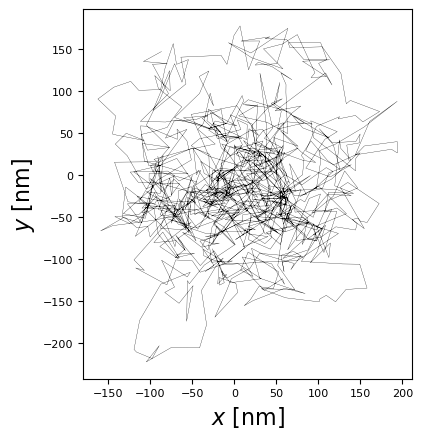

In [206]:
from numpy import pi, sqrt
from tqdm import tqdm

# Parameters
kB = 1.3806e-23 # Boltzman constant [(kg m^2)/(K s^2)]

laser_power = 1e-3 # laser power [W]
T = 293 # absolute temperature [K]
R = 1.0e-6 # radius [m]
eta = 1e-3 # viscosity [Pa s]

gamma = 6 * pi * eta * R # friction coefficient
D = kB * T / gamma # diffusion coefficient

N = 1_000 # number of simulation steps
delta_t = .001 # simulation time step [s]

# Simulation
pos = np.zeros((N, 3))
for t in tqdm(range(N - 1)):
    pos_t = pos[t:t+1]

    pos_t_torch = torch.from_numpy(pos_t).float().to(regressor.device) * 1e6
    force = regressor(pos_t_torch).cpu().detach().numpy() * 1e-15

    pos[t + 1] = (pos_t 
                  + (laser_power / .005) * force / gamma * delta_t 
                  + sqrt(2 * D * delta_t) * np.random.normal(0, 1, size=(1, 3)))

# Plot
plt.plot(pos[:, 0] * 1e+9, pos[:, 1] * 1e+9, "k", linewidth=0.2)
plt.xlabel("$x$ [nm]", fontsize=16)
plt.ylabel("$y$ [nm]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.gca().set_aspect("equal", "box")
plt.show()